In [1]:
library(reticulate)
library(ggplot2)
library(reshape2)
library(dplyr)
use_python("/usr/bin/python3")

git_repo_loc=Sys.getenv("GIT_REPO_LOC")
`%_%` <- function(x, y) { paste(x, y, sep="")}

py_run_string("import sys")
py_run_string("import pickle")
for (py_lib in c("LinearResponseVariationalBayes.py",
                 "BNP_sensitivity/GMM_clustering/",
                 "autograd")) {
    py_run_string("sys.path.append('" %_% file.path(git_repo_loc, py_lib) %_% "')")
}
py_run_string("
import os

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib
from copy import deepcopy

import numpy as np
import scipy as sp
import json 

git_repo = os.environ['GIT_REPO_LOC']
")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
py_run_string("
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/ryan_iris_bnp_full_data_fit.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)
")

In [3]:
py_run_string("
model_refit = deepcopy(model)
print(model.prior_params)

def refit_with_alpha(new_alpha, model, linear_sens):
    model_refit = deepcopy(model)
    model_refit.prior_params['alpha'].set(new_alpha)
    free_par_refit = linear_sens.predict_from_prior_params(
        model_refit.prior_params.get_free())
    model_refit.optimize_full(free_par_refit,
        init_max_iter=100,
        final_max_iter=500)
    return free_par_refit, model_refit.global_vb_params.get_free()
")

In [29]:
py_run_string("
alpha_vec = np.linspace(1, 14, num=14)

print(alpha_vec)
free_par_refit_list = []
free_par_refit_lr_list = []
for alpha in alpha_vec:
    print(alpha)
    free_par_refit_lr, free_par_refit = refit_with_alpha(alpha, model, linear_sens)
    free_par_refit_list.append(free_par_refit)
    free_par_refit_lr_list.append(free_par_refit_lr)
")

In [31]:
py_main <- reticulate::import_main()

GetResultDataFrame <- function(free_par, this_alpha, this_method) {
    py_main$moment_model$set_moments_from_free_par(free_par)
    centroids <- py_main$moment_model$moment_params['centroids']$get()
    cluster_weights <- py_main$moment_model$moment_params['cluster_weights']$get()

    centroid_df <- melt(centroids) %>%
        rename(dim=Var1, k=Var2) %>%
        mutate(alpha=this_alpha, method=this_method, variable="centroid")

    weight_df <- data.frame(value=cluster_weights) %>%
        mutate(dim=-1, k=1:length(cluster_weights)) %>%
        mutate(alpha=this_alpha, method=this_method, variable="cluster_weight")

    return(rbind(weight_df, centroid_df))
}


df_list <- list()

for (i in 1:length(py_main$alpha_vec)) {
    df_list[[length(df_list) + 1]]  <-
        rbind(
            GetResultDataFrame(
                py_main$free_par_refit_list[[i]],
                py_main$alpha_vec[i],
                'truth'),
            GetResultDataFrame(
                py_main$free_par_refit_lr_list[[i]],
                py_main$alpha_vec[i],
                'lr')
        )
}
df <- do.call(rbind, df_list)
head(df)

value,dim,k,alpha,method,variable
0.478342460,-1,1,1,truth,cluster_weight
0.324447981,-1,2,1,truth,cluster_weight
0.014766588,-1,3,1,truth,cluster_weight
0.009119473,-1,4,1,truth,cluster_weight
0.011363342,-1,5,1,truth,cluster_weight
0.009624071,-1,6,1,truth,cluster_weight


alpha,dim,k,variable,lr,truth
1,-1,1,cluster_weight,0.473728003,0.478342460
1,-1,2,cluster_weight,0.324604658,0.324447981
1,-1,3,cluster_weight,0.014956485,0.014766588
1,-1,4,cluster_weight,0.009287308,0.009119473
1,-1,5,cluster_weight,0.011521888,0.011363342
1,-1,6,cluster_weight,0.009784059,0.009624071


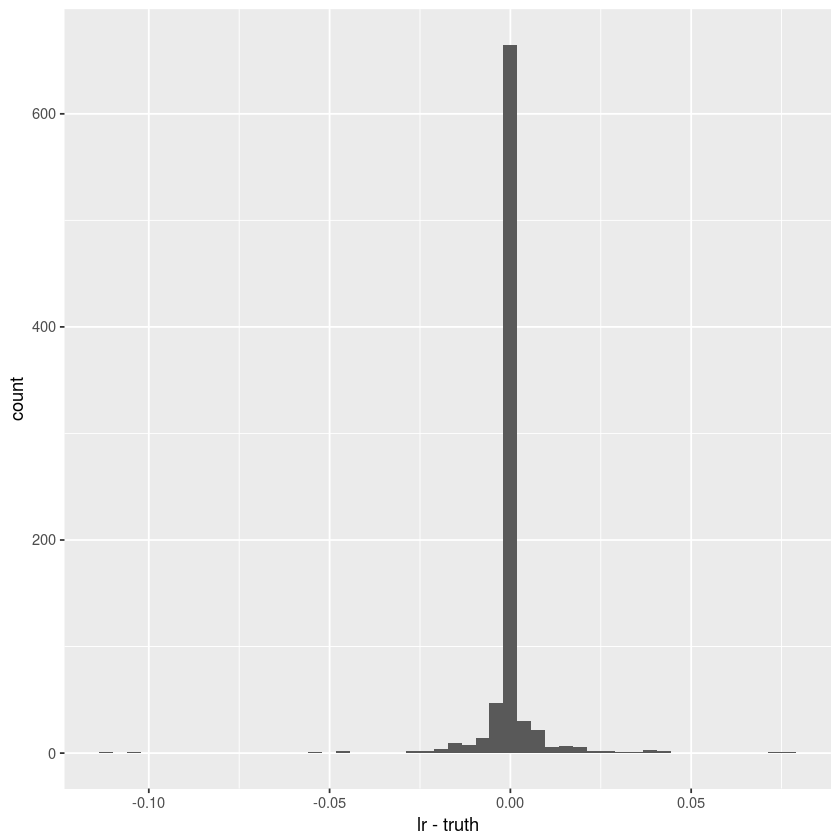

In [32]:
df_cast <- dcast(df, alpha + dim + k + variable ~ method, value.var="value")
head(df_cast)
ggplot(df_cast) +
    geom_histogram(aes(x=lr - truth), bins=50)
# ggplot(df_cast) +
#     geom_line(aes(x=alpha, y=value, color=paste(dim, k))) +
#     facet_grid(dim ~ method, scales="free")

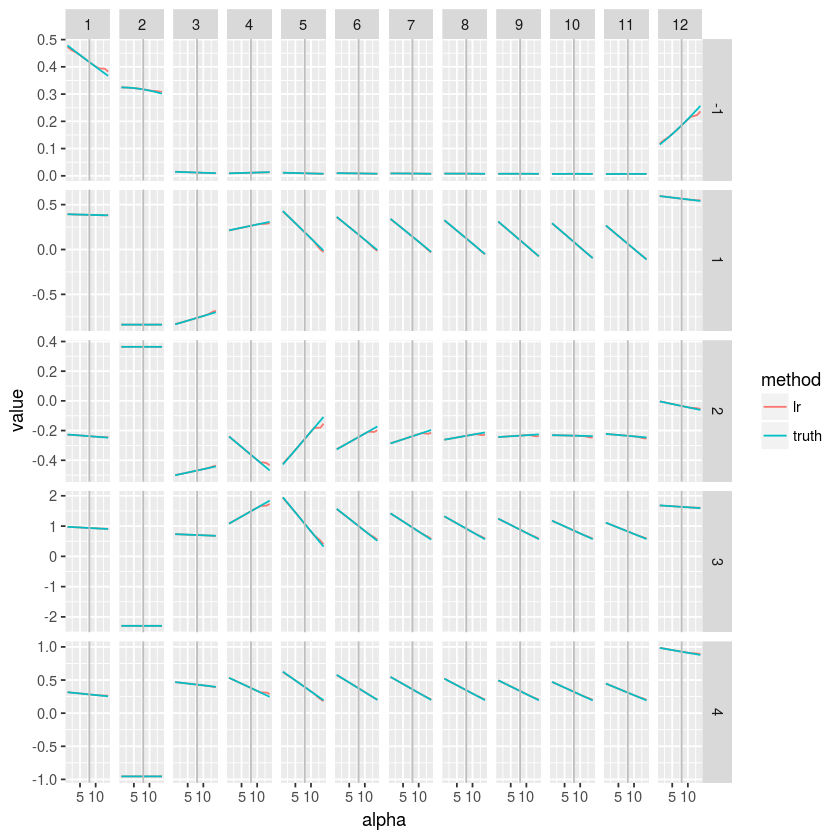

In [33]:
base_alpha <- py_main$model$prior_params['alpha']$get()
ggplot(df) +
    geom_line(aes(x=alpha, y=value, color=method)) +
    geom_vline(aes(xintercept=base_alpha), color="gray") +
    facet_grid(dim ~ k, scales="free")